# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Write the problem in your own words here

In [1]:
#import libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

# from sklearn.svm import SVC

#My info
__author__ = "Dominick DiTucci"
__email__ = "djditucci@gmail.com"

In [2]:
# Create function for distribution plot
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, title):
    width = 10
    height=6
    plt.figure(figsize=(width, height))
    
    ax1=sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2=sns.distplot(BlueFunction, hist=False, color="b", label=BlueName)
    
    plt.title(title)
    plt.xlabel("Proportion of Jobs")
    plt.ylabel("Salary (in thousand dollars)")
    plt.show()
    plt.close()

In [3]:
def PollyPlot(X_train, X_test, y_train, y_test, lr, poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    xmax = max([X_train.values.max(), X_test.values.max()])
    xmin = min([X_train.values.min(), X_test.values.min()])
    x = np.arange(xmin, xmax, 0.1)
    
    plt.plot(X_train, y_train, 'ro', label='Training Data')
    plt.plot(X_test, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predict Function')
    plt.ylim(-100, 5000)
    plt.ylabel('Salary')
    plt.legend

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [4]:
#load the data into a Pandas dataframe
train_feat = pd.read_csv('/Users/DJ/Salary-Prediction-Portfolio/data/train_features.csv')
train_sal = pd.read_csv('/Users/DJ/Salary-Prediction-Portfolio/data/train_salaries.csv')
test_feat = pd.read_csv('/Users/DJ/Salary-Prediction-Portfolio/data/test_features.csv')

# Check data we just loaded
train_feat.head()


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [5]:
train_sal.head()


,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [6]:
test_feat.head()


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


### ---- 3 Clean the data ----

In [7]:
# Look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

# Check shape of our dataframes
print(train_feat.shape)
print(train_sal.shape)
print(test_feat.shape)

# train_feat and test_feat have the same shape. train_feat and train_sal have overlapping 
# information, so let's combine them. We will leave test_feat alone so we can use it to predict 
# salaries after our model is developed

(1000000, 8)
(1000000, 2)
(1000000, 8)


In [8]:
# Join the 2 test dataframes by matching jobId
train_data = pd.merge(train_feat, train_sal, on ='jobId')

# Check merged datafram
train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [9]:
# Check shape of merged df
train_data.shape

(1000000, 9)

In [10]:
# Check for invalid salaries (salaries at or below 0), show with jobid

zero_salary = train_data['salary']<=0
invalid_salary = train_data[zero_salary]

invalid_salary

# There are 5 invalid salaries

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [11]:
# There are only 5/1,000,000 invalid salaries, so we'll remove them
train_data = train_data.drop(invalid_salary.index.tolist())

# See shape after deletion
train_data.shape

(999995, 9)

In [12]:
# Reset index after deletion
train_data.reset_index(drop=True, inplace=True)

# Check last 5 rows to see if index rest
train_data.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999990,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999991,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999992,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999993,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999994,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


In [13]:
# Check for any remaining missing values
missing_data = train_data.isnull().sum()
missing_data


jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [14]:
# See what types of data are in df
print(train_data.dtypes)

# All data types seem appropriate for their labels

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object


In [15]:
# Define categorical variables
train_data['jobId']=pd.Categorical(train_data['jobId'])
train_data['companyId']=pd.Categorical(train_data['companyId'])
train_data['jobType']=pd.Categorical(train_data['jobType'])
train_data['degree']=pd.Categorical(train_data['degree'])
train_data['major']=pd.Categorical(train_data['major'])
train_data['industry']=pd.Categorical(train_data['industry'])
train_data.dtypes

jobId                  category
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

### ---- 4 Explore the data (EDA) ----

In [16]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

# Descriptive statistics of quantitative data
train_data.describe()

# Looking at min, max, mean, and std doesn't show anything obviously wrong

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [17]:
# See how many unique values there are for each category
train_data.nunique()

jobId                  999995
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
salary                    279
dtype: int64

In [18]:
# View relationships between quantitative data
train_data.corr()

# Salary and yearsExperience have weak positive correlation
# Salary and milesFromMetropolis have weka negative correlaiton

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000672,0.375013
milesFromMetropolis,0.000672,1.000000,-0.297686
salary,0.375013,-0.297686,1.000000


Salary Skewness: 0.34652727907668734
Salary Kurtosis: -0.025750772283374967
Salary distribution is approximately symmetric


/Users/DJ/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


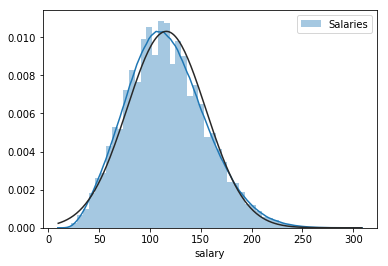

In [19]:
# Are salaries normally distrubuted?
print('Salary Skewness:', train_data['salary'].skew())
print('Salary Kurtosis:', train_data['salary'].kurt())

if -0.5 <= train_data['salary'].skew() <= 0.5:
    print('Salary distribution is approximately symmetric')
elif -0.5 >  train_data['salary'] > 0.5:
    print('Salary distribution is skewed')

sns.distplot(train_data['salary'], fit=norm, label='Salaries')
plt.legend()

(0, 315.2775030364004)

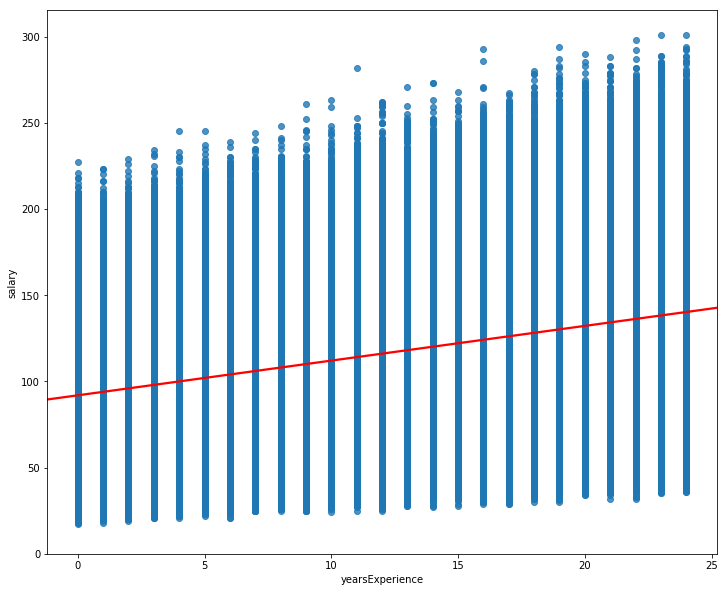

In [20]:
# Visualize yearsExperience as predictor of salary
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x='yearsExperience', y='salary', data=train_data, line_kws={'color':'red'})
plt.ylim(0,)

# Data is widely spread from regression line, may need to apply transformation

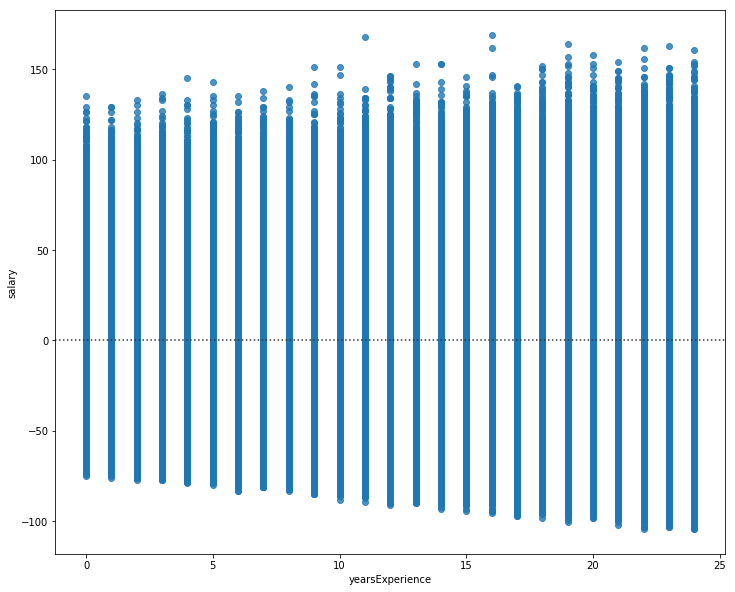

In [21]:
# Visualize variance of yearsExperience
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.residplot(train_data['yearsExperience'], train_data['salary'])
plt.show()

# Slightly more variance with more years experience

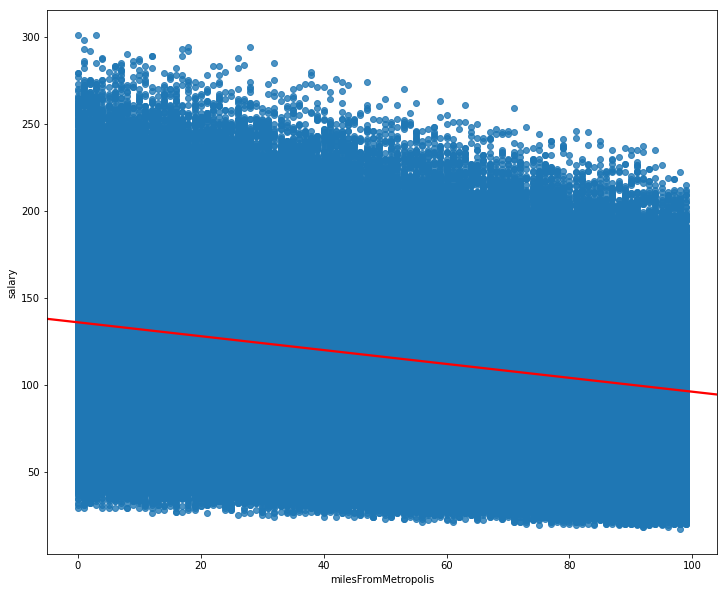

In [22]:
# Visualize milesFromMetropolis as predictor of salary
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x='milesFromMetropolis', y='salary', data=train_data, line_kws={'color':'red'})

# Data is widely spread from regression line, may need to apply transformation

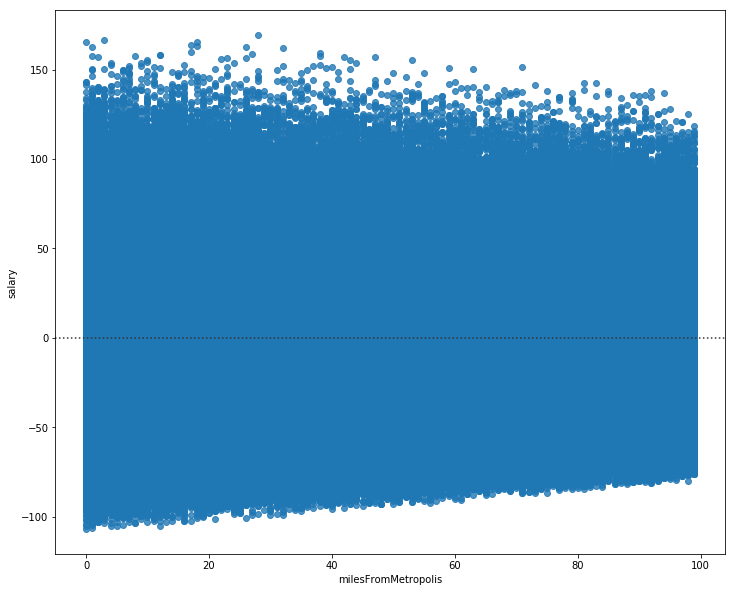

In [23]:
# Visualize variance of milesFromMetropolis
width = 12
height = 10 
plt.figure(figsize=(width, height))
sns.residplot(train_data['milesFromMetropolis'], train_data['salary'])
plt.show()

# Slightly less variance with more miles from metropolis

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 <a list of 63 Text xticklabel objects>)

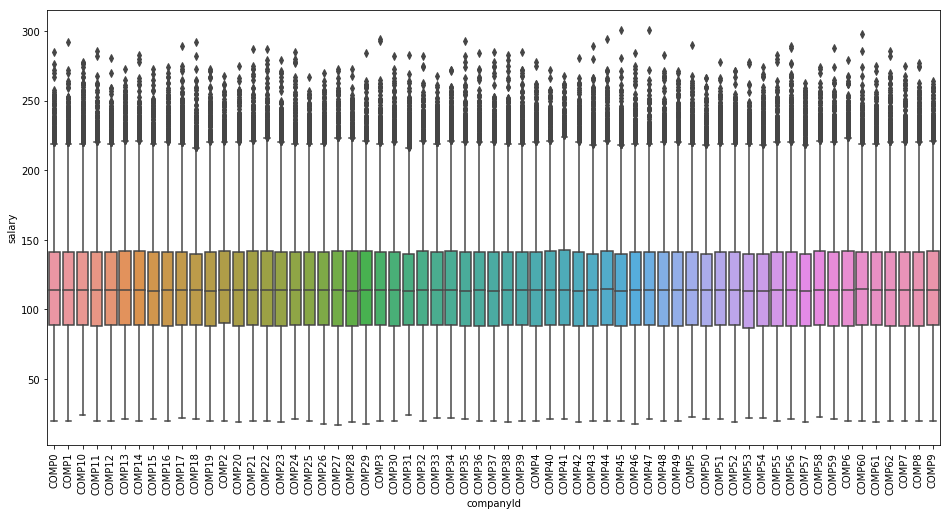

In [24]:
# See if any company in our data is significantly out of range from others
width = 16
height = 8
var = 'companyId'
data = pd.concat([train_data['salary'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(width, height))
fig = sns.boxplot(x=var, y='salary', data=data)
plt.xticks(rotation=90)

# companyId shows mostly evenly distributed salaries and does not seem to 
# be a good predictor for salary

In [25]:
# jobId is irrelevant for prediction purposes, so we'll remove it
# companyId doesn't seem to be a significant factor either, so we'll remove that too

train_data.drop('jobId', axis=1, inplace=True)
train_data.drop('companyId', axis=1, inplace=True)

# View data after removing jobId and companyId
train_data.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,CFO,MASTERS,MATH,HEALTH,10,83,130
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

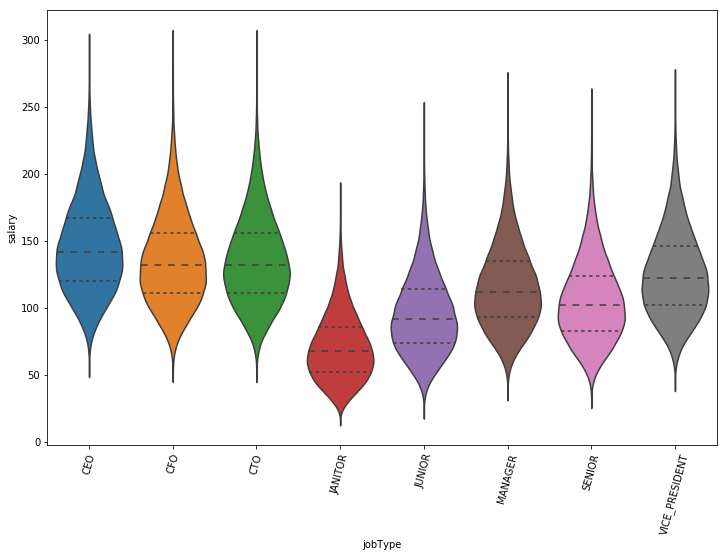

In [26]:
# Repeat visualization for all categorical data to see what factors may affect salary
width = 12
height = 8
var = 'jobType'
data = pd.concat([train_data['salary'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(width, height))
fig = sns.violinplot(x=var, y='salary', data=data, scale='count', inner='quartile')
plt.xticks(rotation=75)

# Highest salaries are CEO, followed by CFO and CTO. Lowest is Janitor followed by Junior
# Distributions appear normal

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

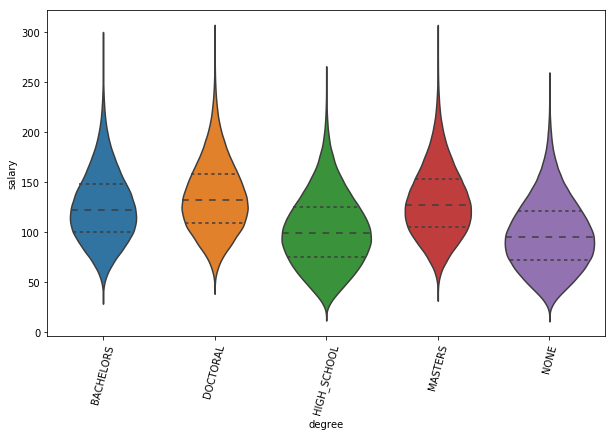

In [27]:
width = 10
height = 6
var = 'degree'
data = pd.concat([train_data['salary'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(width, height))
fig = sns.violinplot(x=var,y='salary', data=data, scale='count', inner='quartile')
plt.xticks(rotation=75)

# Having a degree seems to give a higher salary than high school or no degree
# Distributions appear normal

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

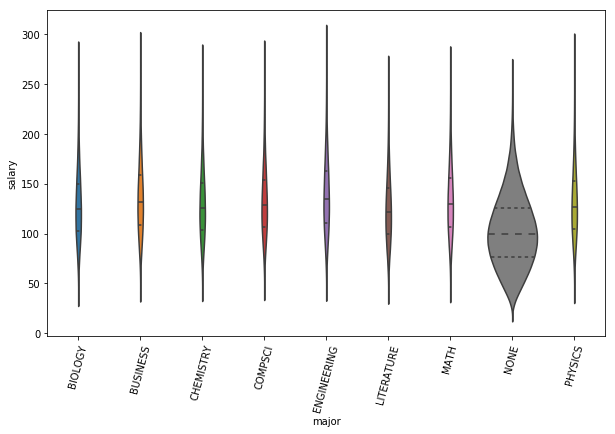

In [28]:
width = 10
height = 6
var = 'major'
data = pd.concat([train_data['salary'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(width, height))
fig = sns.violinplot(x=var, y='salary', data=data, scale='count', inner='quartile')
plt.xticks(rotation=75)

# Having no major seems to have lower salaries than having a major
# Distributions appear normal

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

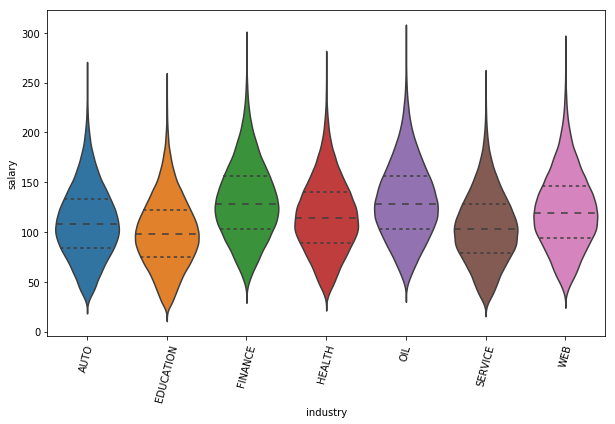

In [29]:
width = 10
height = 6
var = 'industry'
data = pd.concat([train_data['salary'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(width, height))
fig = sns.violinplot(x=var, y='salary', data=data, scale='count', inner='quartile')
plt.xticks(rotation=75)

# The oil industry, followed by finance and web, seem to have highest salaries. 
# Education and service seem to have the lowest
# Distributions appear normal

In [30]:
# Assign dummy variables to categorical data
train_data= pd.get_dummies(train_data)
train_data.head()

,yearsExperience,milesFromMetropolis,salary,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,130,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,101,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10,38,137,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,8,17,142,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,8,16,163,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


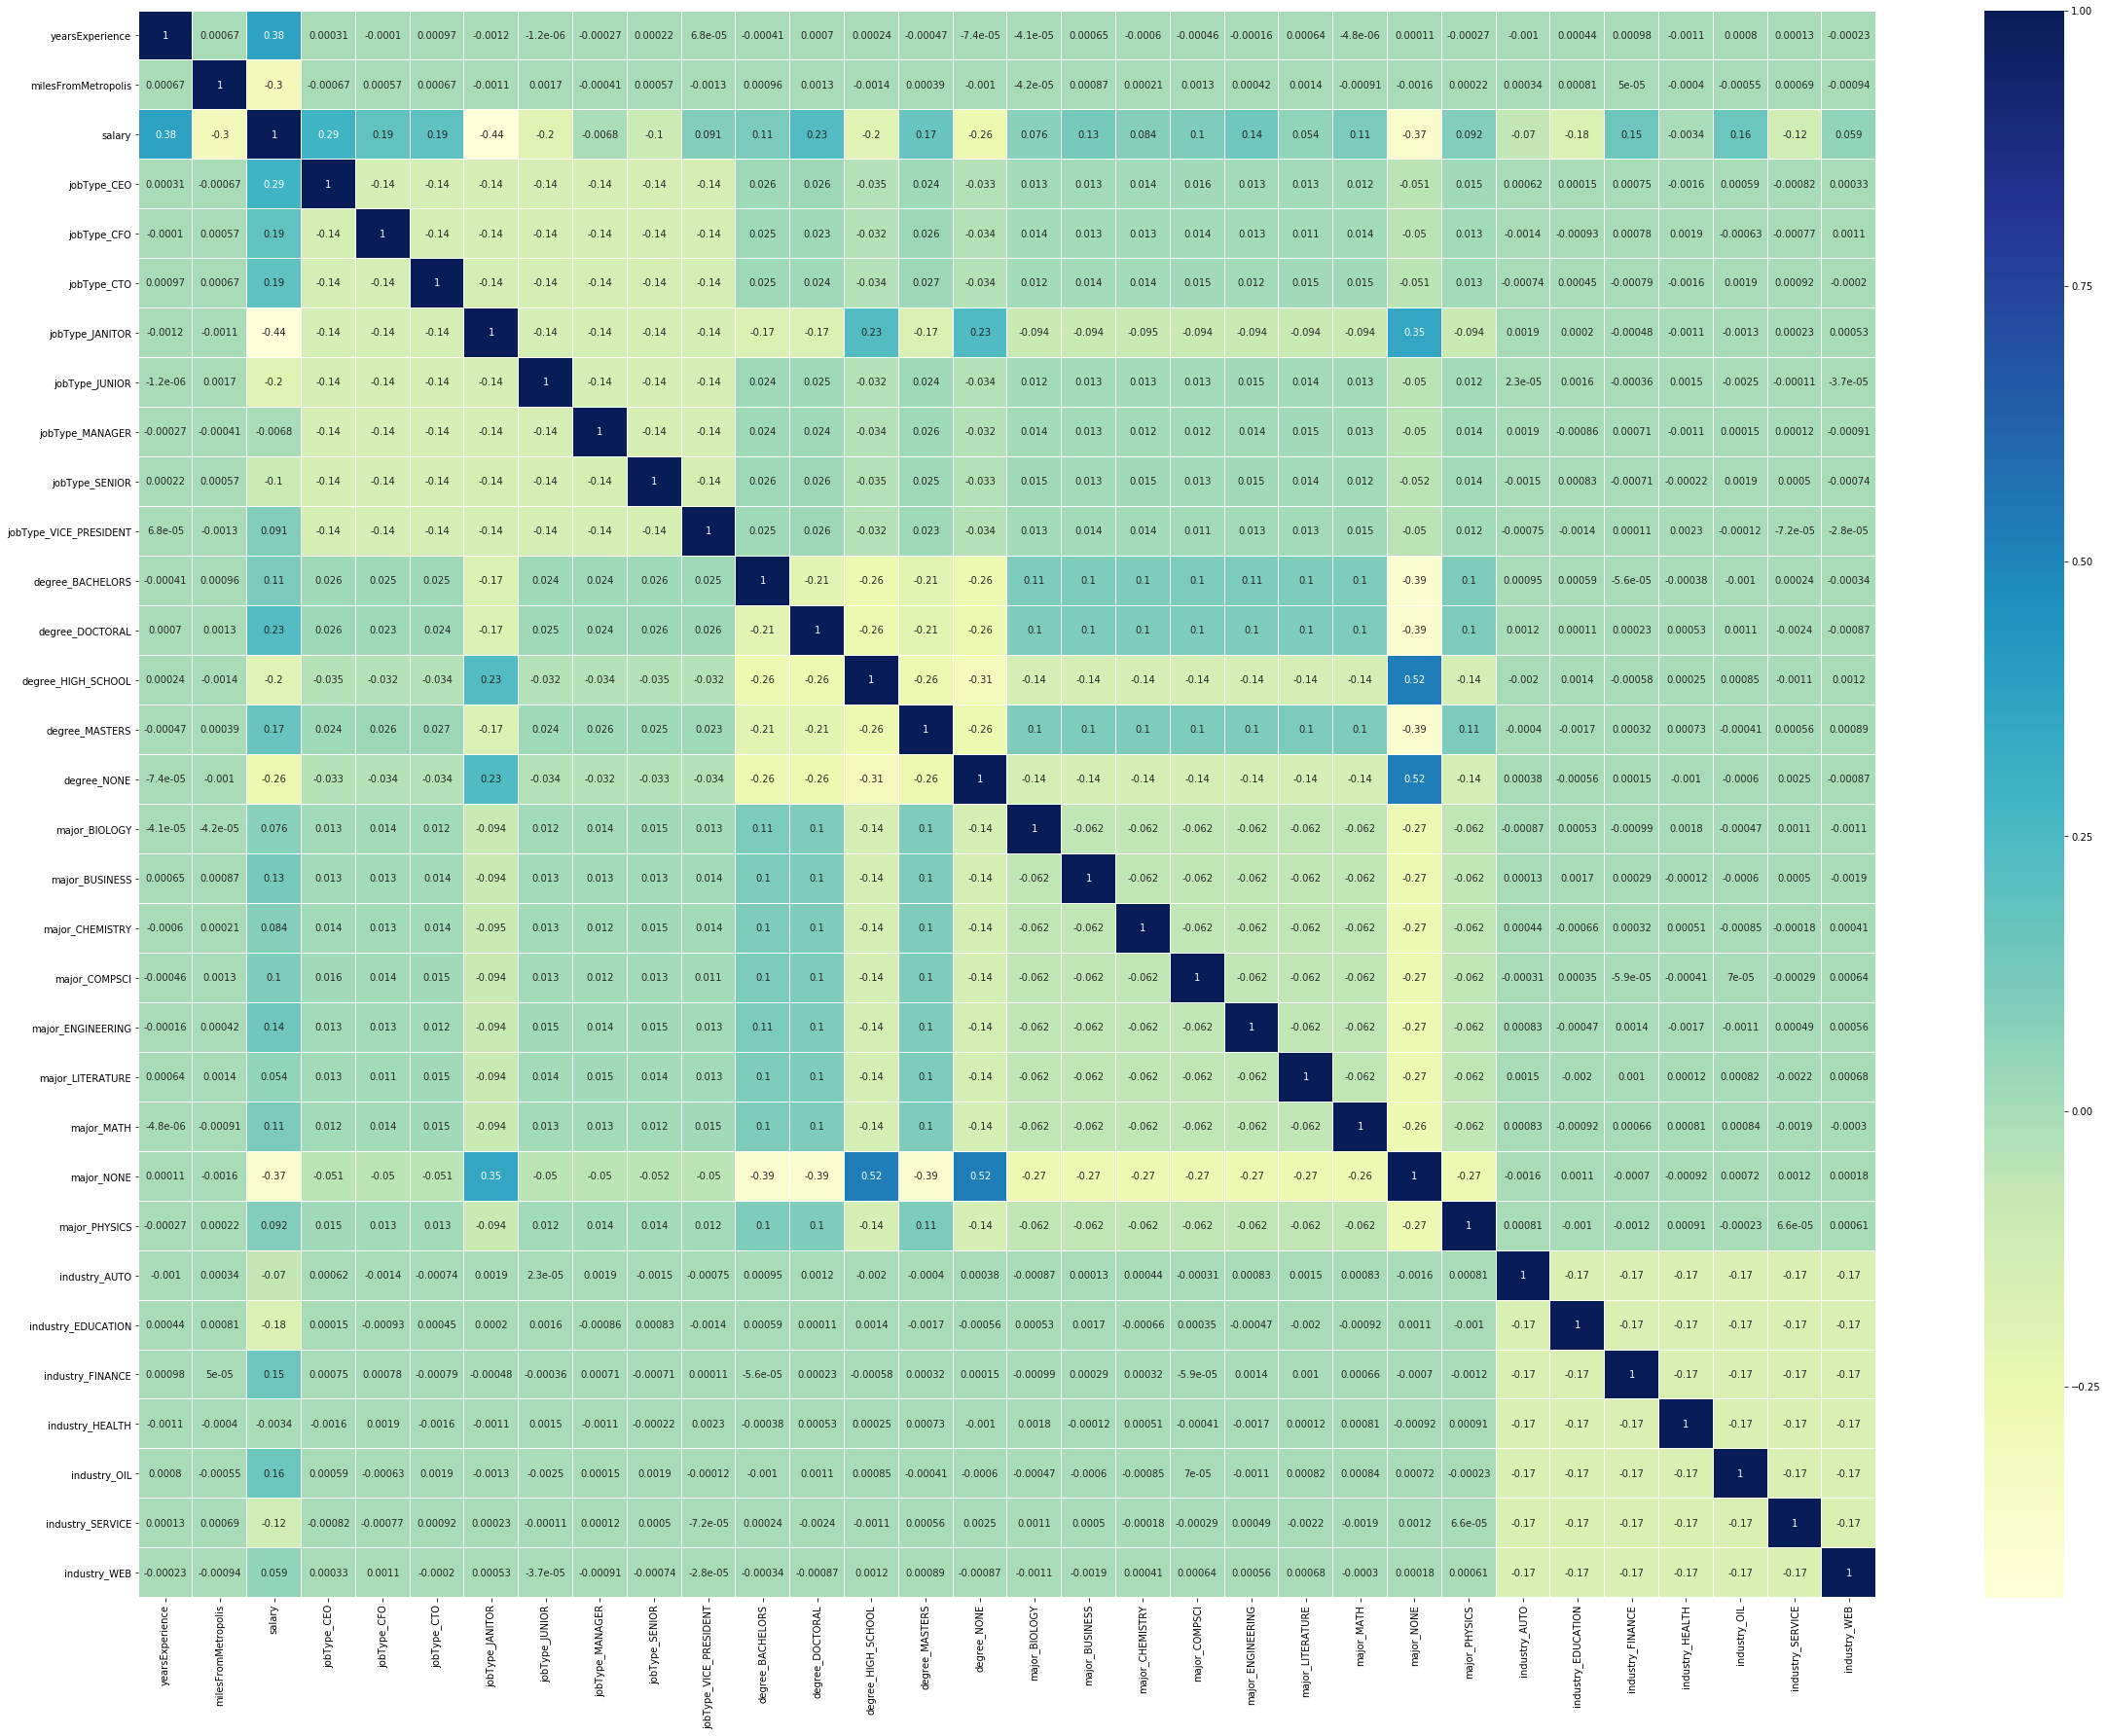

In [31]:
# View heatmap with correlation coefficients
train_data_corr = train_data.corr()
plt.subplots(figsize=(40,30))
sns.heatmap(train_data_corr, cmap='YlGnBu', linewidth=.005, annot=True)

# yearsExperience has highest correlation with salary

### ---- 5 Establish a baseline ----

In [32]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation


In [32]:
# Create training model
X = train_data[train_data.loc[ : , train_data.columns != 'salary'].columns]
y = train_data['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [33]:
print('Inputs: \n', X_train.head())
print('Outputs: \n', y_train.head())

Inputs: 
         yearsExperience  milesFromMetropolis  jobType_CEO  jobType_CFO  \
583582               17                   75            0            0   
465088               14                   88            1            0   
686214               12                   65            0            0   
176612                8                   68            0            0   
249785                3                   13            0            0   

        jobType_CTO  jobType_JANITOR  jobType_JUNIOR  jobType_MANAGER  \
583582            0                0               0                0   
465088            0                0               0                0   
686214            0                0               1                0   
176612            0                0               0                0   
249785            0                0               0                0   

        jobType_SENIOR  jobType_VICE_PRESIDENT      ...       major_MATH  \
583582               0        

In [34]:
# Use Linear Regression since salary is continuous range.
# Create linear regression object and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [35]:
# View coefficients
print(lm.intercept_)
print(lm.coef_)

-86634823223.50609
[ 2.01083748e+00 -3.99646056e-01  8.04771398e+10  8.04771397e+10
  8.04771397e+10  8.04771397e+10  8.04771397e+10  8.04771397e+10
  8.04771397e+10  8.04771397e+10  5.09177623e+09  5.09177624e+09
  5.09177622e+09  5.09177624e+09  5.09177622e+09  2.70775313e+08
  2.70775321e+08  2.70775314e+08  2.70775317e+08  2.70775324e+08
  2.70775309e+08  2.70775318e+08  2.70775308e+08  2.70775315e+08
  7.95132059e+08  7.95132049e+08  7.95132080e+08  7.95132065e+08
  7.95132080e+08  7.95132054e+08  7.95132071e+08]


In [36]:
# Predict y given X (yhat) and view 1st 5 predictions for train data
yhat = lm.predict(X_train)
print("The output of the first five predicted values are:", yhat[0:5])

The output of the first five predicted values are: [126.75590515 144.06837463  93.90647888 113.80305481 133.2784729 ]


In [37]:
# Find MSE of training data
print("The mean squared error of our prediciton model is:", mean_squared_error(y_train, yhat))


The mean squared error of our prediciton model is: 384.2694852161028


In [38]:
# Predict yhat for test data
yhat_test = lm.predict(X_test)
yhat_test[0:5]

array([157.80125427,  62.36587524, 108.70870972, 112.59100342,
        92.52095032])

In [39]:
# Find MSE of test data

print("The output of our first five test predicitons is:", mean_squared_error(y_test, yhat_test))

The output of our first five test predicitons is: 384.83003943796683


In [40]:
# Model Performance on train data
scores = cross_val_score(lm, X_train, y_train, cv=5)
print("5-Fold Cross Validation Accuracy (train data):", (np.mean(scores)), (np.std(scores)))

5-Fold Cross Validation Accuracy (train data): 0.7433246233006936 0.0005871258620038212


/Users/DJ/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


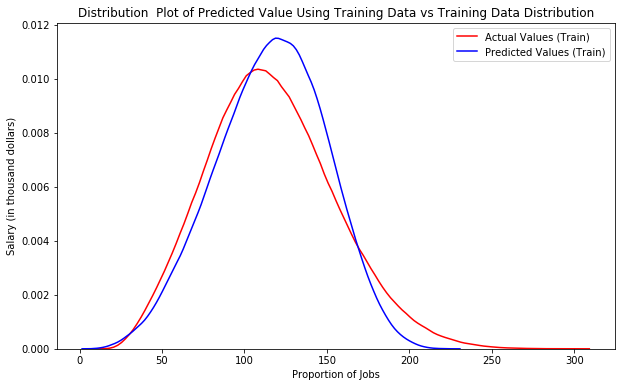

In [41]:
# View distribution of actual vs fitted
Title = 'Distribution  Plot of Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat, "Actual Values (Train)", "Predicted Values (Train)", Title)


In [42]:
# Model Performance on test data
scores = cross_val_score(lm, X_test, y_test, cv=5)
print("5-Fold Cross Validation Accuracy (test data):", (np.mean(scores)), (np.std(scores)))

5-Fold Cross Validation Accuracy (test data): 0.7443984755769636 0.0027138769296562097


/Users/DJ/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


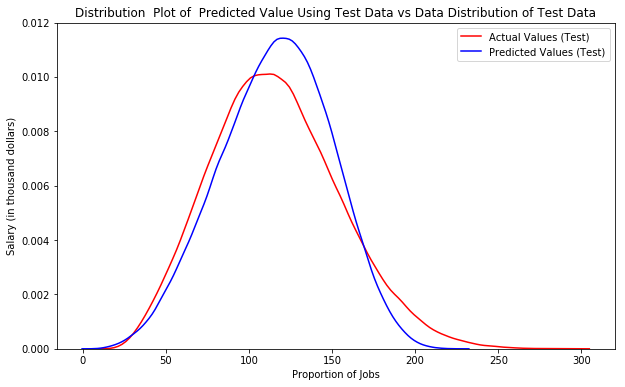

In [43]:
# View distribution of actual vs fitted test data
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

In [45]:
# Distribution, accuracy score, and MSE are not incredibly different when comparing the training and testing data.
# We will see if MSE can be reduced from 384 to below 360

### ---- 6 Hypothesize solution ----

In [46]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

# 1: Preprocess using polynomial feature
# 2: Use ridge regression
# 3: apply random forrest

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [47]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

In [44]:
# See columns and shape of training and test data
print("Number of test samples:", X_test.shape, "\nwith these features:\n", X_test.columns)
print("\nNumber of training samples:", X_train.shape, "\nwith these features:\n", X_train.columns)
print("\nNumber of test salaries:", y_test.shape)
print("Number of training salaries:", y_train.shape)

Number of test samples: (199999, 31) 
with these features:
 Index(['yearsExperience', 'milesFromMetropolis', 'jobType_CEO', 'jobType_CFO',
       'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR', 'jobType_MANAGER',
       'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'degree_BACHELORS',
       'degree_DOCTORAL', 'degree_HIGH_SCHOOL', 'degree_MASTERS',
       'degree_NONE', 'major_BIOLOGY', 'major_BUSINESS', 'major_CHEMISTRY',
       'major_COMPSCI', 'major_ENGINEERING', 'major_LITERATURE', 'major_MATH',
       'major_NONE', 'major_PHYSICS', 'industry_AUTO', 'industry_EDUCATION',
       'industry_FINANCE', 'industry_HEALTH', 'industry_OIL',
       'industry_SERVICE', 'industry_WEB'],
      dtype='object')

Number of training samples: (799996, 31) 
with these features:
 Index(['yearsExperience', 'milesFromMetropolis', 'jobType_CEO', 'jobType_CFO',
       'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR', 'jobType_MANAGER',
       'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'degree_BACHE

### ---- 8 Create models ----

In [49]:
#create and tune the models that you brainstormed during part 2

In [45]:
# Perform polynomial transformation 
pr = PolynomialFeatures(2)
X_train_pr = pr.fit_transform(X_train)
X_test_pr = pr.fit_transform(X_test)
pr

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)

In [46]:
# Create new linear regression model using polynomial transformation
poly = LinearRegression()
poly.fit(X_train_pr, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [47]:
# View first five preictions train data
yhat_prTrain = poly.predict(X_train_pr)
yhat_prTrain[0:5]

array([122.81038292, 154.60249718,  93.9342614 , 108.47322091,
       124.48774823])

In [48]:
# Compare predicted train values to true values
print("Predicted Values:", yhat_prTrain[0:5])
print("True Values:", y_test[0:5].values)

Predicted Values: [122.81038292 154.60249718  93.9342614  108.47322091 124.48774823]
True Values: [186  67  82 104 106]


In [49]:
# View first five preictions test data
yhat_prTest = poly.predict(X_test_pr)
yhat_prTest[0:5]

array([159.44733056,  60.11526497,  96.82036027,  99.60062941,
        93.33856209])

In [50]:
# Compare predicted test values to true values
print("Predicted Values:", yhat_prTest[0:5])
print("True Values:", y_test[0:5].values)

Predicted Values: [159.44733056  60.11526497  96.82036027  99.60062941  93.33856209]
True Values: [186  67  82 104 106]


In [51]:
# R^2 of train and test data
print("R-squared of training data:", poly.score(X_train_pr, y_train))
print("R-squared of test data:", poly.score(X_test_pr, y_test))

# Minor (.02) improvement over base model
# 2nd order train/test=0.764/0.765

R-squared of training data: 0.7638922148909846
R-squared of test data: 0.7645110452346376


In [52]:
# MSE of train and test data
print("MSE of training data:", mean_squared_error(y_train, yhat_prTrain))
print("MSE of test data:", mean_squared_error(y_test, yhat_prTest))

# 2nd ordr train/test=353.515/354.654

MSE of training data: 353.5146528542993
MSE of test data: 354.6540319030929


In [ ]:
# Model Performance on train data
scores = cross_val_score(poly, X_train_pr, y_train, cv=5)
print("5-Fold Cross Validation Accuracy (train data):", (np.mean(scores)), (np.std(scores)))

In [ ]:
# Model Performance on test data
scores = cross_val_score(poly, X_test_pr, y_test, cv=5)
print("5-Fold Cross Validation Accuracy (test data):", (np.mean(scores)), (np.std(scores)))

/Users/DJ/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


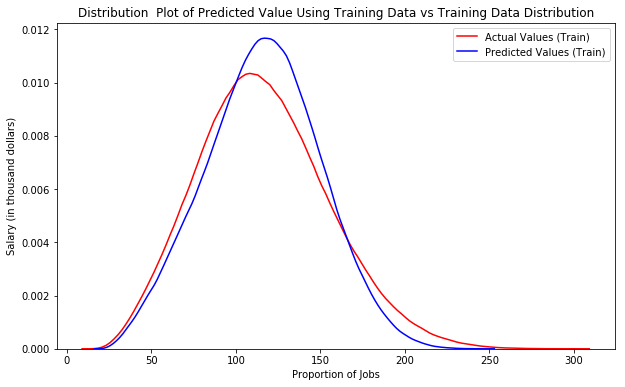

In [53]:
# View distribution of actual vs fitted
Title = 'Distribution  Plot of Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_prTrain, "Actual Values (Train)", "Predicted Values (Train)", Title)


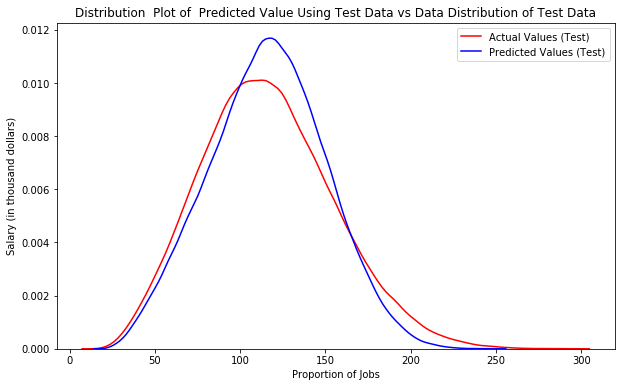

In [54]:
# View distribution of actual vs fitted test data
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_prTest,"Actual Values (Test)","Predicted Values (Test)",Title)

In [55]:
# See if applying ridge regression gets lower MSE
# Create ridge regression object 

RidgeModel = Ridge(alpha=1.0)

In [56]:
# Fit ridge model
RidgeModel.fit(X_train_pr, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [57]:
# Predict values
yhat_ridge_train = RidgeModel.predict(X_train_pr)
yhat_ridge_test = RidgeModel.predict(X_test_pr)

In [58]:
# compare predicted train values to actual train values
print('Predicted:', yhat_ridge_train[0:4])
print('Actual :', y_train[0:4].values)

Predicted: [122.80535226 154.60016552  93.93272274 108.47222045]
Actual : [ 90 164  87 126]


In [59]:
# compare predicted test values to actual test values
print('Predicted:', yhat_ridge_test[0:4])
print('Actual :', y_test[0:4].values)

Predicted: [159.45593431  60.11135936  96.82007354  99.5978305 ]
Actual : [186  67  82 104]


In [60]:
# See R^2 of train and trst data
print("R-squared of training data:", RidgeModel.score(X_train_pr, y_train))
print("R-squared of test data:", RidgeModel.score(X_test_pr, y_test))
# No significant improvement

R-squared of training data: 0.7638922261902712
R-squared of test data: 0.7645108187953095


In [61]:
# See MSE of train and test data
print("MSE of training data:", mean_squared_error(y_train, yhat_ridge_train))
print("MSE of test data:", mean_squared_error(y_test, yhat_ridge_test))

# No improvement using alpha [0.1, 1.0, 10.0, 100.0, 1000.0]

MSE of training data: 353.5146359363337
MSE of test data: 354.6543729280925


In [ ]:
# Model Performance on train data
scores = cross_val_score(RidgeModel, X_train_pr, y_train, cv=5)
print("5-Fold Cross Validation Accuracy (train data):", (np.mean(scores)), (np.std(scores)))

In [ ]:
# Model Performance on test data
scores = cross_val_score(RidgeModel, X_test_pr, y_test, cv=5)
print("5-Fold Cross Validation Accuracy (test data):", (np.mean(scores)), (np.std(scores)))

In [62]:
# Use gridsearch to ensure best hyperparameter used
# Create dictionary of alpha values
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

In [63]:
# Create new ridge regression object
RR = Ridge()
RR

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [64]:
# Create ridge grid search object
Grid1 = GridSearchCV(RR, parameters1, cv=5)

In [65]:
# Fit the model to training data
Grid1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [66]:
# assign best estimator
bestRR = Grid1.best_estimator_
bestRR

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [67]:
# Test model using test data
bestRR.score(X_test, y_test)

# No improvement using alpha = 1.0

0.7444743887739421

In [ ]:
# Model Performance on train data
scores = cross_val_score(RR, X_train, y_train, cv=5)
print("5-Fold Cross Validation Accuracy (train data):", (np.mean(scores)), (np.std(scores)))

In [ ]:
# Model Performance on test data
scores = cross_val_score(RR, X_test, y_test, cv=5)
print("5-Fold Cross Validation Accuracy (test data):", (np.mean(scores)), (np.std(scores)))

In [68]:
# Instantiate and fit random forest model with random_state=1 for consistency

rf = RandomForestRegressor(n_estimators=1000, random_state=1)


In [69]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [70]:
# View predictions

predictions = rf.predict(X_test)
predictions[0:5]

array([170.5755    ,  61.15505238,  90.37748333,  98.5285    ,
       106.54405   ])

In [71]:
# View R^2 and MSE
print("R-squared of test data:", rf.score(X_test, y_test))
print("MSE of test data:", mean_squared_error(y_test, predictions))

R-squared of test data: 0.707887081666257
MSE of test data: 439.9315643541132


In [ ]:
# Model Performance on train data
scores = cross_val_score(rf, X_train, y_train, cv=5)
print("5-Fold Cross Validation Accuracy (train data):", (np.mean(scores)), (np.std(scores)))

In [ ]:
# Model Performance on test data
scores = cross_val_score(rf, X_test, y_test, cv=5)
print("5-Fold Cross Validation Accuracy (test data):", (np.mean(scores)), (np.std(scores)))

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "production" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data